##Graphs for metals stacked##
based on scraped by-metal data in data/<metal_name>

Edited: 5/23


analysis by year
Edited: 5/29

added separate graphs for value and quantity to compare to other 2 stages
Edited: 6/5

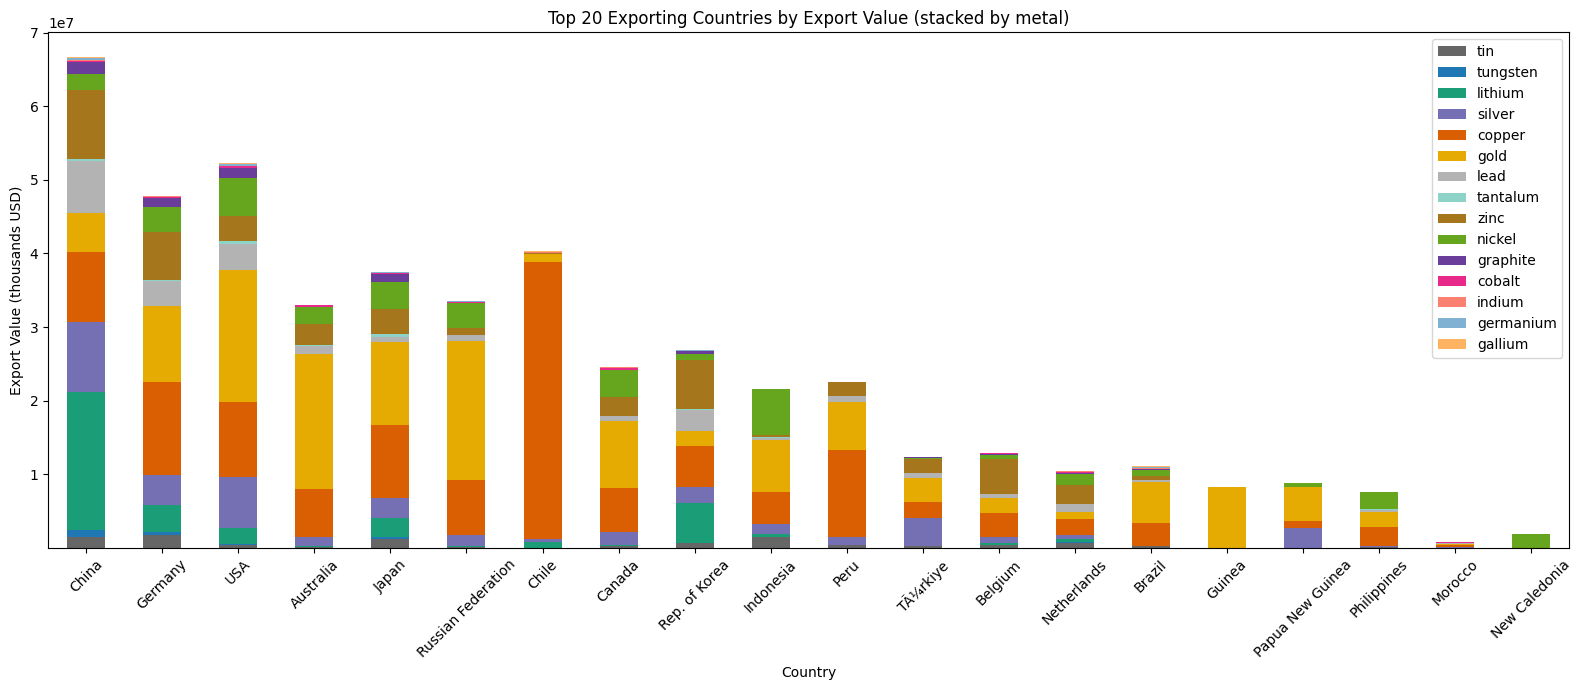

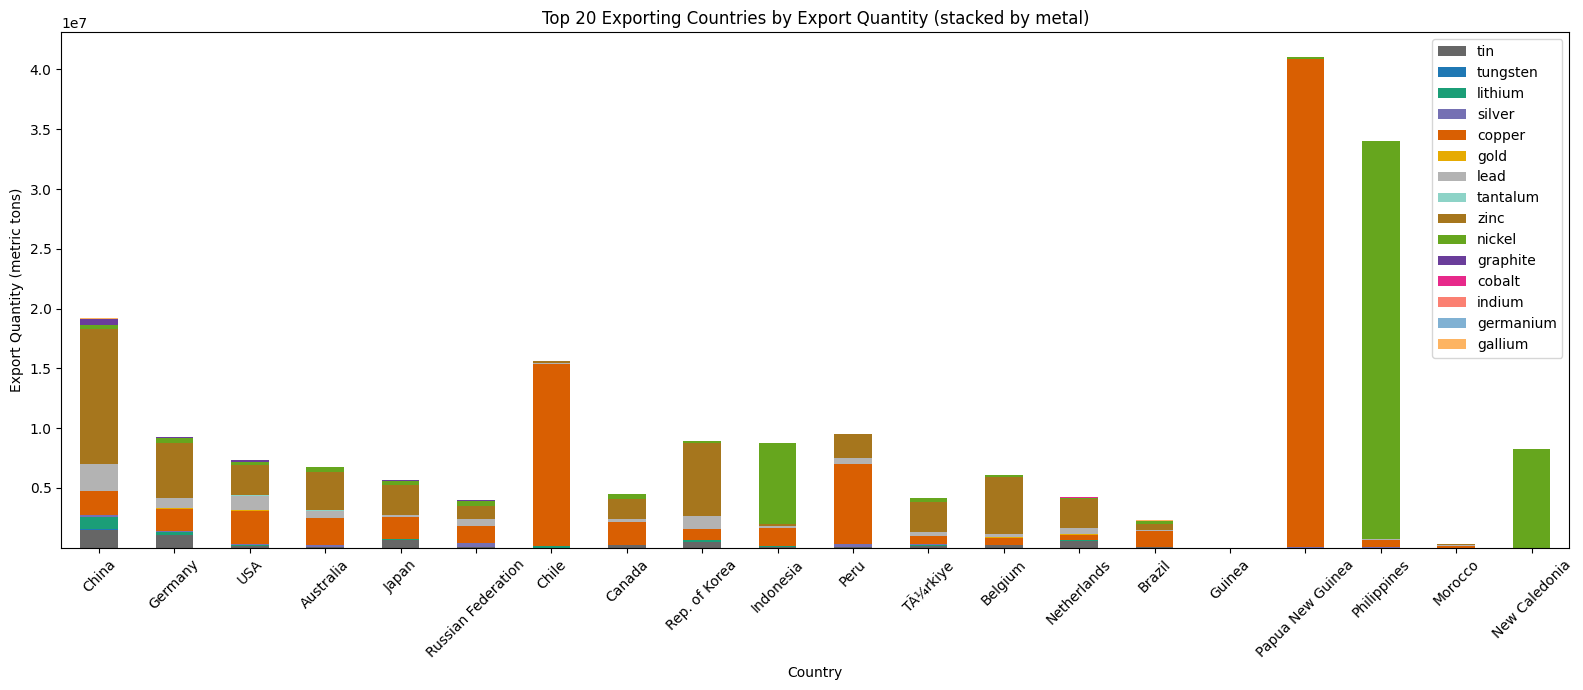

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIGURATION ===
base_dir = "../data"
country_code_file = "../ref/country_codes_V202501.csv"
metal_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

years = [2020]

# Load country codes
country_df = pd.read_csv(country_code_file)
country_lookup = dict(zip(country_df["country_code"], country_df["country_name"]))

# Standardized metal color palette
color_map = {
    "copper": "#d95f02", "gold": "#e6ab02", "silver": "#7570b3", "lithium": "#1b9e77",
    "nickel": "#66a61e", "cobalt": "#e7298a", "zinc": "#a6761d", "tin": "#666666",
    "tungsten": "#1f78b4", "graphite": "#6a3d9a", "rare earth": "#ff7f00",
    "tantalum": "#8dd3c7", "indium": "#fb8072", "germanium": "#80b1d3", "gallium": "#fdb462", "lead": "#b3b3b3"
}

# "aluminium": "#b2df8a",

export_value = defaultdict(lambda: defaultdict(float))
export_quantity = defaultdict(lambda: defaultdict(float))

for metal in metal_dirs:
    trade_path = os.path.join(base_dir, metal, "trade_data.csv")
    if not os.path.exists(trade_path):
        continue

    try:
        df = pd.read_csv(trade_path)
        df = df.rename(columns={"i": "exporter", "j": "importer", "k": "hs_code", "v": "value", "q": "quantity"})

        for target_year in years:
            df = df[df["year"] == target_year]

        grouped = df.groupby("exporter").agg({"value": "sum", "quantity": "sum"}).reset_index()

        for _, row in grouped.iterrows():
            export_value[int(row["exporter"])][metal] += row["value"]
            export_quantity[int(row["exporter"])][metal] += row["quantity"]

    except Exception as e:
        print(f"[ERROR] Failed to process {metal}: {e}")

value_df = pd.DataFrame(export_value).T.fillna(0)
quantity_df = pd.DataFrame(export_quantity).T.fillna(0)

# Map exporter codes to country names
value_df.index = value_df.index.map(lambda x: country_lookup.get(x, f"Code {x}"))
quantity_df.index = quantity_df.index.map(lambda x: country_lookup.get(x, f"Code {x}"))

# Get top 20 exporters by quantity
top_countries = quantity_df.sum(axis=1).nlargest(20).index
value_df = value_df.loc[top_countries]
quantity_df = quantity_df.loc[top_countries]

# Prepare color list for valid metals
valid_metals = [col for col in value_df.columns if col in color_map]
colors = [color_map[m] for m in valid_metals]

total_quantity = quantity_df.sum(axis=1)
total_value = value_df.sum(axis=1)

top_exporters = total_value.nlargest(20).index

# Filter rows
value_df_top = value_df.loc[top_exporters]
quantity_df_top = quantity_df.loc[top_exporters]

valid_metals = [col for col in value_df_top.columns if col in color_map]
colors = [color_map[m] for m in valid_metals]

# export value plots
fig, ax = plt.subplots(figsize=(16, 7))
value_df_top[valid_metals].plot(kind="bar", stacked=True, color=colors, ax=ax)
ax.set_title("Top 20 Exporting Countries by Export Value (stacked by metal)")
ax.set_ylabel("Export Value (thousands USD)")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# export quantity plots
fig, ax = plt.subplots(figsize=(16, 7))
quantity_df_top[valid_metals].plot(kind="bar", stacked=True, color=colors, ax=ax)
ax.set_title("Top 20 Exporting Countries by Export Quantity (stacked by metal)")
ax.set_ylabel("Export Quantity (metric tons)")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


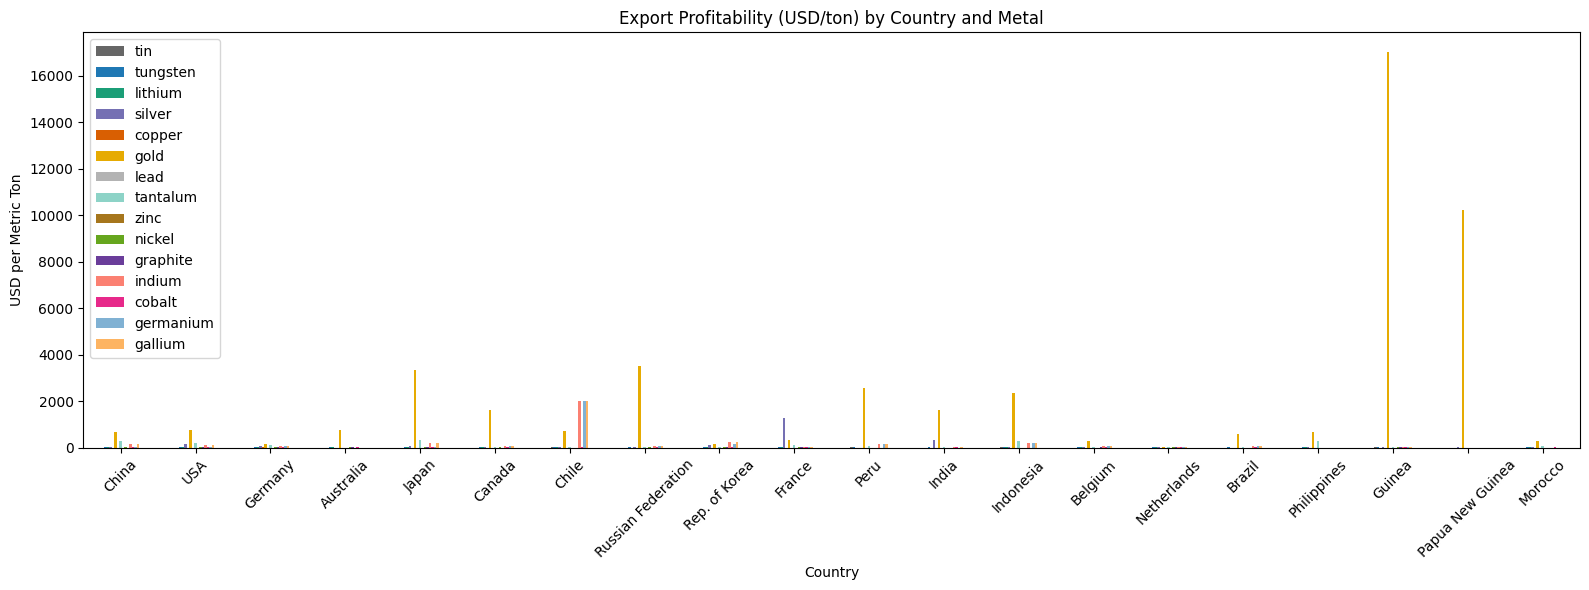

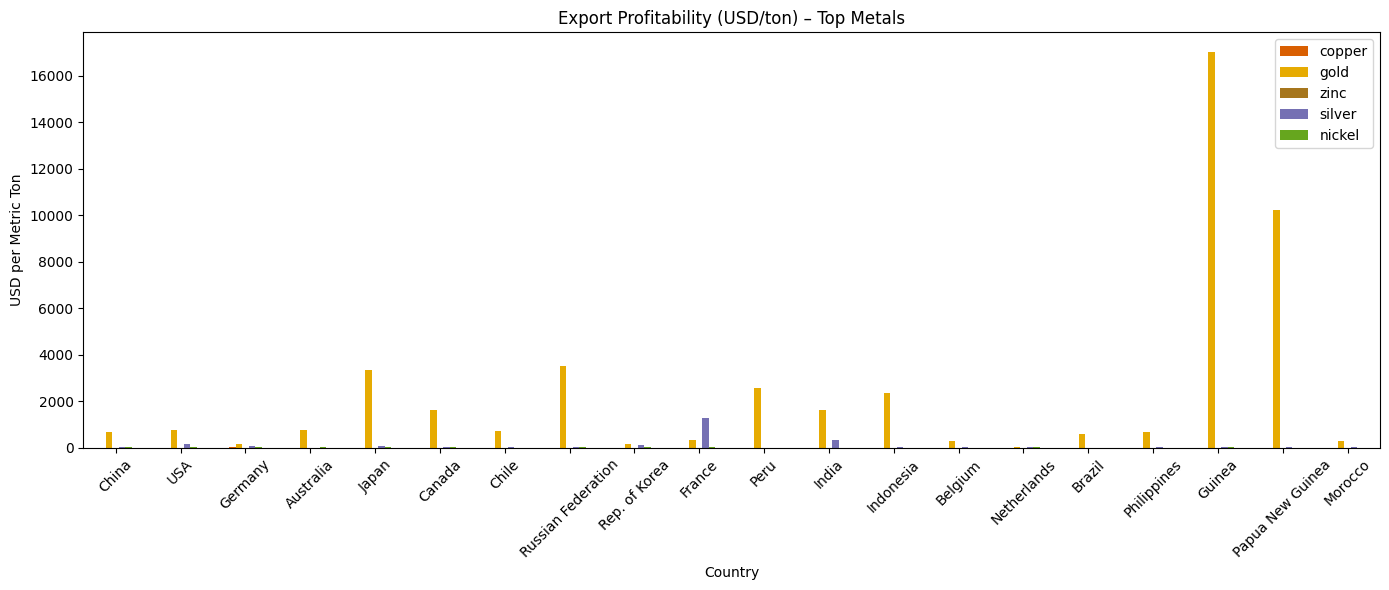

In [5]:
# === USD PER TON ANALYSIS ===
# Replace zeros with NaN to avoid divide-by-zero in profitability calc
quantity_df_clean = quantity_df.replace(0, float('nan'))
value_per_ton_df = value_df / quantity_df_clean

# Filter for top exporters only
value_per_ton_top = value_per_ton_df.loc[top_exporters]

# === PLOT PROFITABILITY ===
fig, ax = plt.subplots(figsize=(16, 6))
value_per_ton_top[valid_metals].plot(kind="bar", ax=ax, color=colors)
ax.set_title("Export Profitability (USD/ton) by Country and Metal")
ax.set_ylabel("USD per Metric Ton")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === EXPORT PROFILE RATIO ===
# Normalize values: value as a % of total export value by country
normalized_value = value_df.div(value_df.sum(axis=1), axis=0)
normalized_quantity = quantity_df.div(quantity_df.sum(axis=1), axis=0)

# Compute imbalance: who exports more value relative to tonnage
profile_diff = normalized_value - normalized_quantity
profile_diff_top = profile_diff.loc[top_exporters]


top_metals = value_df[valid_metals].sum().nlargest(5).index.tolist()
top_colors = [color_map[m] for m in top_metals]

# === USD PER TON ===
quantity_df_clean = quantity_df.replace(0, float('nan'))
value_per_ton_df = value_df / quantity_df_clean
value_per_ton_top = value_per_ton_df.loc[top_exporters]

fig, ax = plt.subplots(figsize=(14, 6))
value_per_ton_top[top_metals].plot(kind="bar", ax=ax, color=top_colors)
ax.set_title("Export Profitability (USD/ton) – Top Metals")
ax.set_ylabel("USD per Metric Ton")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



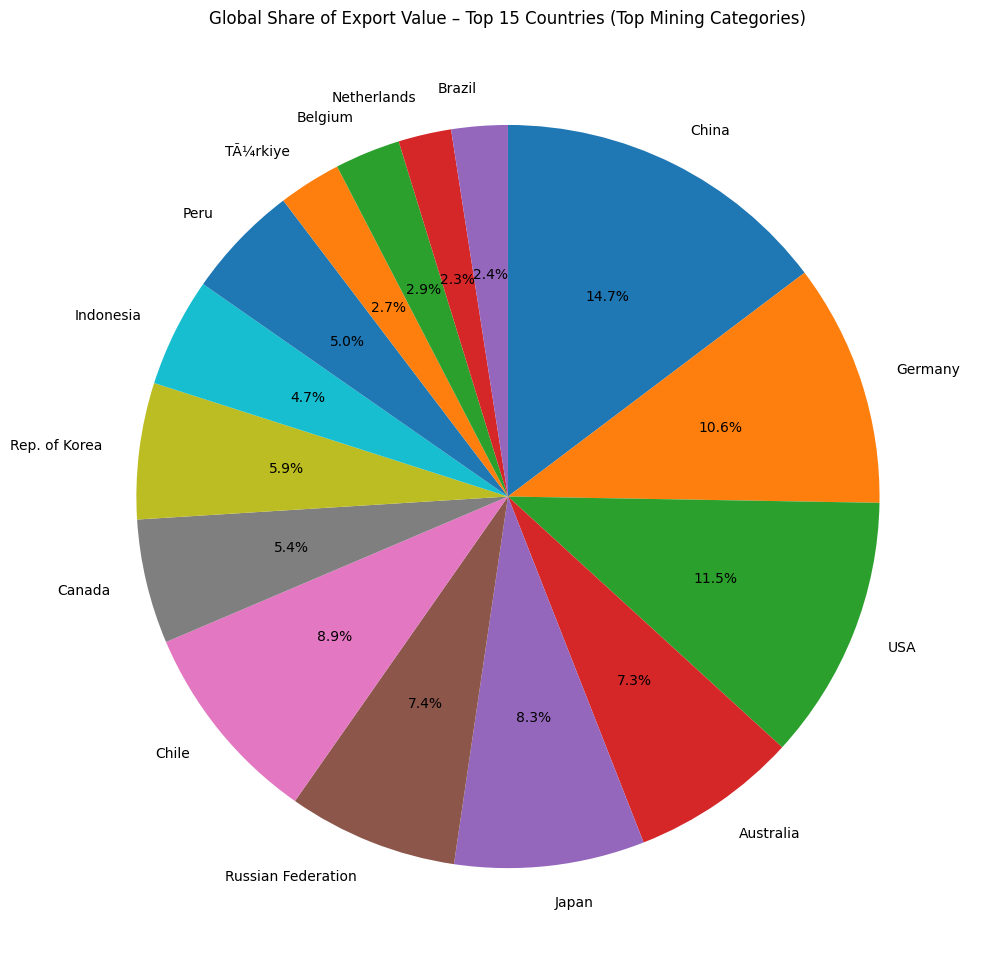

In [3]:
# === GLOBAL SHARE OF EXPORT VALUE (MANUFACTURING) ===
valid_categories = [col for col in value_df_top.columns if col in color_map]

global_total_value = value_df[valid_categories].sum().sum()
share_value = value_df[valid_categories].sum(axis=1) / global_total_value * 100
share_value_top = share_value[top_exporters[:15]]  # Top 15 exporters

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(
    share_value_top,
    labels=share_value_top.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
)
ax.set_title("Global Share of Export Value – Top 15 Countries (Top Mining Categories)")
plt.tight_layout()
plt.show()


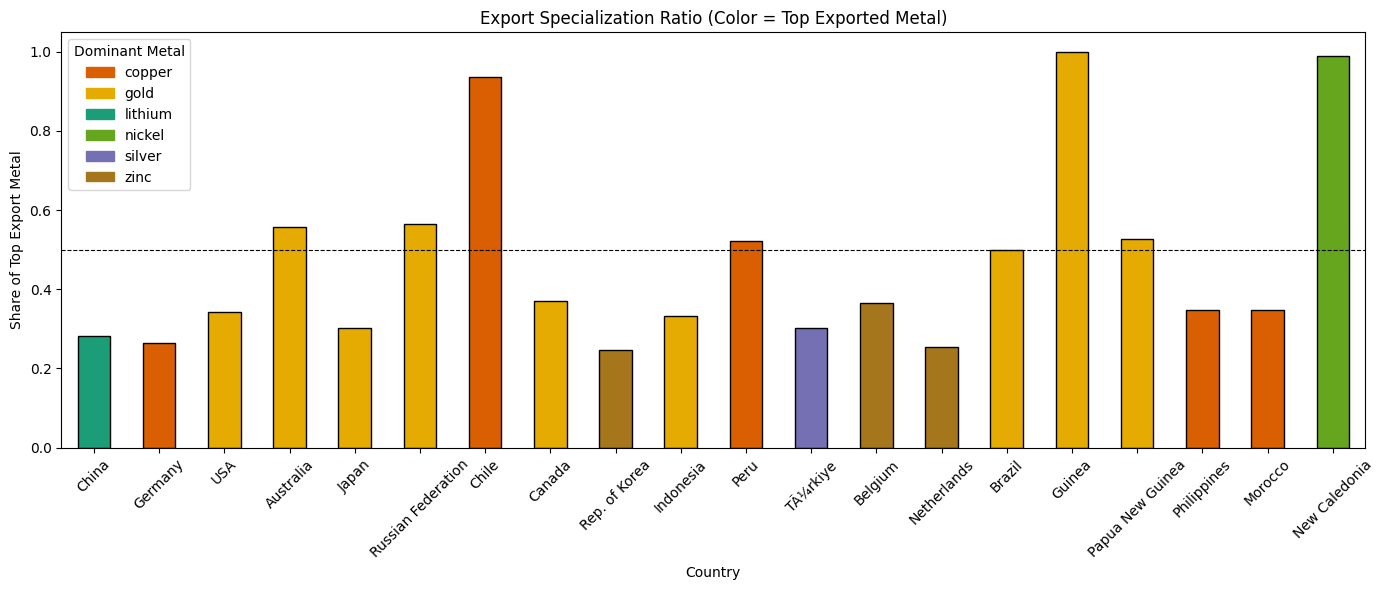

In [4]:
#metal concentration 
concentration_ratio = value_df[valid_metals].div(value_df[valid_metals].sum(axis=1), axis=0)
max_share_per_country = concentration_ratio.max(axis=1)
top_metal_per_country = concentration_ratio.idxmax(axis=1)

#coordinate colors
bar_colors = top_metal_per_country[top_exporters].map(color_map)

#plot
fig, ax = plt.subplots(figsize=(14, 6))
max_share_per_country[top_exporters].plot(
    kind='bar',
    ax=ax,
    color=bar_colors,
    edgecolor='black'
)

# Legend setup
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[m]) for m in sorted(set(top_metal_per_country[top_exporters]))]
labels = sorted(set(top_metal_per_country[top_exporters]))

ax.set_title("Export Specialization Ratio (Color = Top Exported Metal)")
ax.set_ylabel("Share of Top Export Metal")
ax.set_xlabel("Country")
plt.axhline(0.5, color="black", linestyle="--", linewidth=0.8)
plt.xticks(rotation=45)
ax.legend(handles, labels, title="Dominant Metal")
plt.tight_layout()
plt.show()


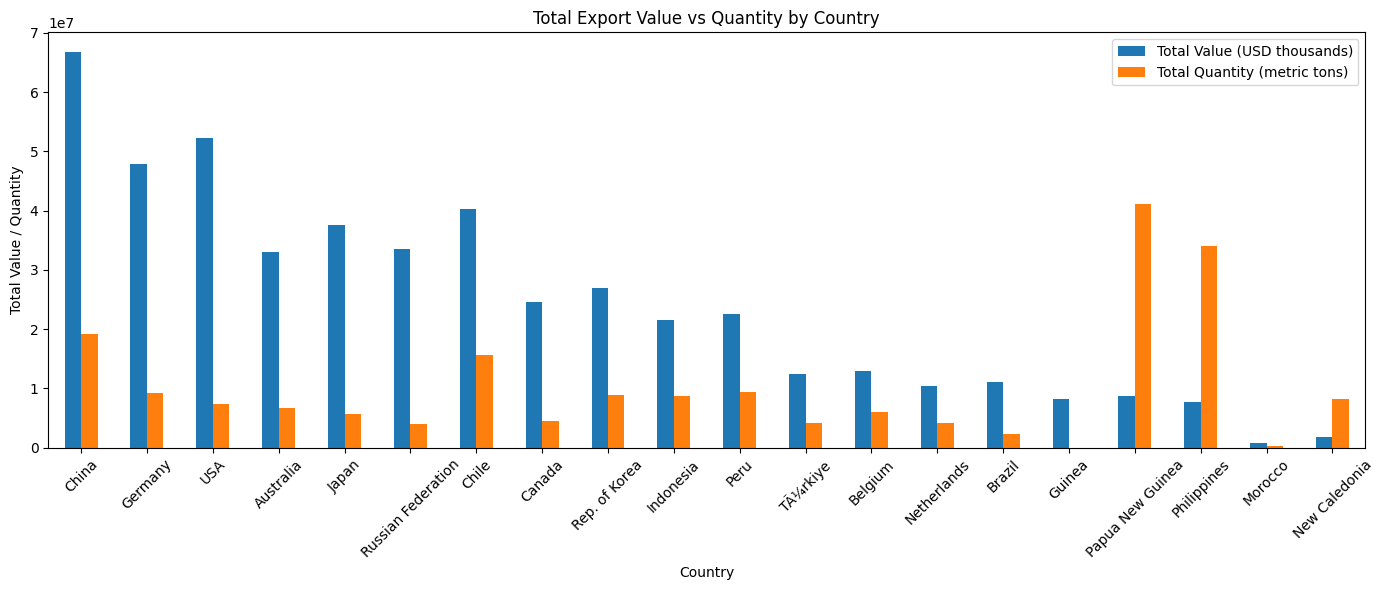

In [5]:
#export value and quantity side-by-side
total_val = value_df[valid_metals].sum(axis=1)
total_qty = quantity_df[valid_metals].sum(axis=1)

comparison_df = pd.DataFrame({
    "Total Value (USD thousands)": total_val[top_exporters],
    "Total Quantity (metric tons)": total_qty[top_exporters]
})

fig, ax = plt.subplots(figsize=(14, 6))
comparison_df.plot(kind="bar", ax=ax)
ax.set_title("Total Export Value vs Quantity by Country")
ax.set_ylabel("Total Value / Quantity")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


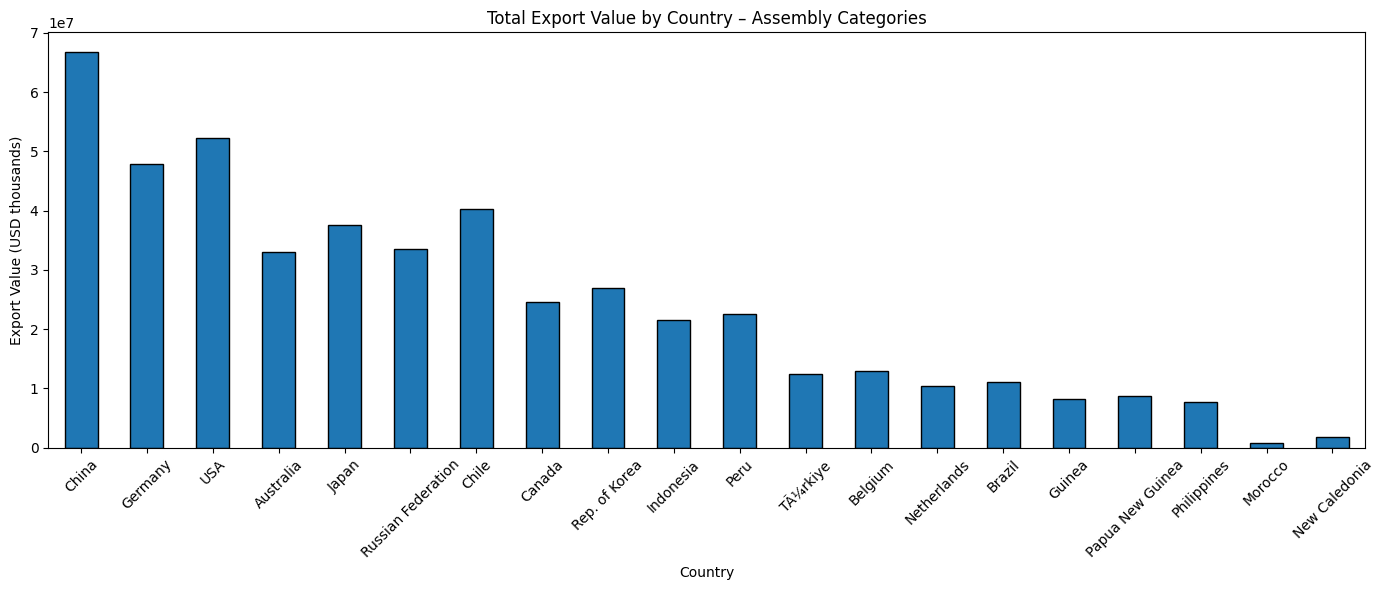

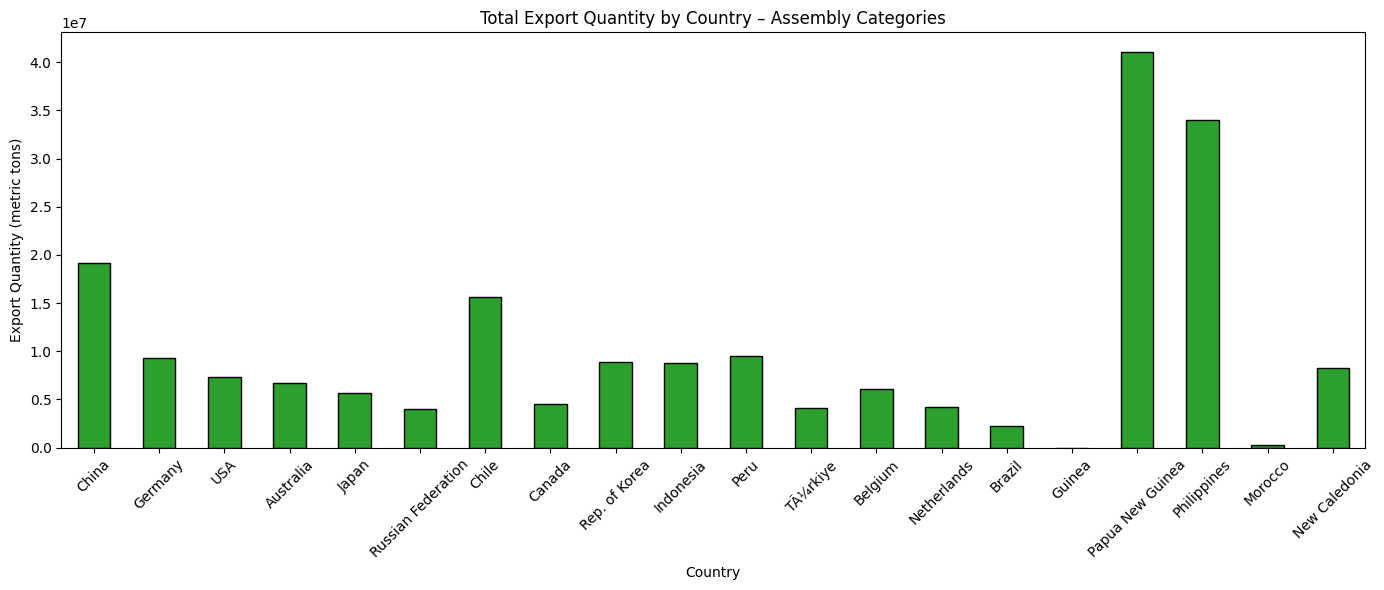

In [6]:
# === EXPORT VALUE VS QUANTITY: Assembly ===

# Compute totals for selected categories
total_val = value_df[valid_categories].sum(axis=1)
total_qty = quantity_df[valid_categories].sum(axis=1)

# Select only top exporters
total_val_top = total_val[top_exporters]
total_qty_top = total_qty[top_exporters]

# === PLOT: Total Export Value ===
fig, ax1 = plt.subplots(figsize=(14, 6))
total_val_top.plot(kind="bar", ax=ax1, color="#1f77b4", edgecolor="black")
ax1.set_title("Total Export Value by Country – Assembly Categories")
ax1.set_ylabel("Export Value (USD thousands)")
ax1.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === PLOT: Total Export Quantity ===
fig, ax2 = plt.subplots(figsize=(14, 6))
total_qty_top.plot(kind="bar", ax=ax2, color="#2ca02c", edgecolor="black")
ax2.set_title("Total Export Quantity by Country – Assembly Categories")
ax2.set_ylabel("Export Quantity (metric tons)")
ax2.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
